In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

# from matplotlib.colors import to_rgb, to_rgba

# def scatter(x, y, color, alpha_arr, **kwarg):
#     r, g, b = to_rgb(color)
#     # r, g, b, _ = to_rgba(color)
#     color = [(r, g, b, alpha) for alpha in alpha_arr]
#     plt.scatter(x, y, c=color, **kwarg)

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import sys
sys.path.append('../')
from core import networks
from core import toy_data
from core import models

In [57]:
def sample_data(name, batch_size):
    x = toy_data.inf_train_gen(name, batch_size=batch_size)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

def plot_samples(samples):
    samples = samples[(samples[:,0] > -3.5) * (samples[:,0] < 3.5)]
    samples = samples[(samples[:,1] > -3.5) * (samples[:,1] < 3.5)]
    _ = plt.hist2d(samples.detach().cpu().numpy()[:,0], 
                   samples.detach().cpu().numpy()[:,1], 
                   bins=70, cmap=my_cmap)
    
@torch.no_grad()
def plot_ebm_density(ebm):
    x = torch.linspace(-3.5,3.5,100)
    y = torch.linspace(-3.5,3.5,100)
    x_grid,y_grid = torch.meshgrid(x,y)
    pdf = torch.exp(-ebm(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2]))).detach()
    pdf = pdf.numpy().reshape([100, 100])
    plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
    
def plot_training_process(method_name, data_name, seed):
    log = pd.read_csv('../logs/%s_%s_seed_%d.csv' % (method_name, data_name, seed))

    fs = 15
    figsize(16,5)
    plt.subplot(131)
    plt.plot(log['loss'])
    plt.ylabel('loss', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    plt.subplot(132)
    plt.plot(log['mmd'])
    plt.ylabel('MMD^2', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    plt.subplot(133)
    plt.plot(log['logl'])
    plt.ylim(-4.5,-2.5)
    plt.ylabel('logl', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    
def plot_final_model(method_name, data_name, seed, relu=False):
    if 'gamma' in method_name:
        gamma_E = torch.load('../checkpoints/%s_%s_seed_%d' % (method_name, data_name, seed), map_location=device)
    else:
        net = networks.SmallMLP(2, relu=relu)
        base_dist = distributions.Normal(torch.zeros(2), torch.ones(2))
        ebm = models.EBM(net, base_dist).cpu()
        ebm.load_state_dict(torch.load('../checkpoints/%s_%s_seed_%d' % (method_name, data_name, seed), 
                                       map_location=device))

    particles = torch.load('../checkpoints/particles_%s_%s_seed_%d' % (method_name, data_name, seed), 
                           map_location=device)
    train_data = sample_data(data_name, 1000)
    
    
    figsize(16,5)
    plt.subplot(131)
    plot_samples(train_data)
    plt.subplot(132)
    plot_samples(particles)
    plt.subplot(133)
    if 'gamma' in method_name:
        x = torch.linspace(-5.,5.,200)
        y = torch.linspace(-5.,5.,200)
        x_grid,y_grid = torch.meshgrid(x,y)
        pdf = np.exp(-gamma_E.numpy()).reshape([200, 200])
        plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
        plt.xlim(-3.5,3.5)
        plt.ylim(-3.5,3.5)
    else:
        plot_ebm_density(ebm)
        
def plot_models(models_names, data_name, name_map, seed=0):
    figsize(16,6)
    fs = 17
    n = len(models_names)+1
    #target
    train_data = sample_data(data_name, 1000)
    target_dist = toy_data.gaussian8()
    plt.subplot(2,n,1)
    plt.title('Target', fontsize=fs)
    plt.ylabel('Density', fontsize=fs)
    plt.xticks([])
    plot_ebm_density(lambda x: -target_dist.log_prob(x))
    plt.subplot(2,n,1+n)
    plt.ylabel('Particles', fontsize=fs)
    plot_samples(train_data)
    
    i = 2
    for method_name in models_names:
        if 'gamma' in method_name:
            continue
        net = networks.SmallMLP(2, relu=False)
        base_dist = distributions.Normal(torch.zeros(1).sum(), torch.ones(1).sum())
        ebm = models.EBM(net, base_dist).cpu()
        ebm.load_state_dict(torch.load('../checkpoints/%s_%s_seed_%d' % (method_name, data_name, seed), 
                                       map_location=device))
        particles = torch.load('../checkpoints/particles_%s_%s_seed_%d' % (method_name, data_name, seed), 
                               map_location=device)
        plt.subplot(2,n,i)
        plt.title(name_map[method_name], fontsize=fs)
        plt.xticks([])
        plt.yticks([])
        plot_ebm_density(ebm)
        plt.subplot(2,n,i+n)
        plt.yticks([])
        plot_samples(particles)
        i += 1
        
    gamma_models = list(filter(lambda name: 'gamma' in name, models_names))    
    for method_name in gamma_models:
        gamma_E = torch.load('../checkpoints/%s_%s_seed_%d' % (method_name, data_name, seed), 
                             map_location=device)
        particles = torch.load('../checkpoints/particles_%s_%s_seed_%d' % (method_name, data_name, seed), 
                               map_location=device)
        plt.subplot(2,n,i)
        x = torch.linspace(-5.,5.,200)
        y = torch.linspace(-5.,5.,200)
        x_grid,y_grid = torch.meshgrid(x,y)
        pdf = np.exp(-gamma_E.numpy()).reshape([200, 200])
        plt.title(name_map[method_name], fontsize=fs)
        plt.xticks([])
        plt.yticks([])
        plt.xlim(-3.5,3.5)
        plt.ylim(-3.5,3.5)
        plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
        plt.subplot(2,n,i+n)
        plt.yticks([])
        plot_samples(particles)
        i += 1
    plt.tight_layout()
    
def plot_trainings(models_names, data_name, seeds, name_map):
    fs = 15
    figsize(12,6)
    plt.subplot(121)
    for method_name in models_names:
        logl = np.zeros(10000)
        for s in seeds:
            log = pd.read_csv('../logs/%s_%s_seed_%d.csv' % (method_name, data_name, s))
            logl += log['logl'] / len(seeds)
#         kernel_smth = np.arange(100)
#         kernel_smth = kernel_smth/np.sum(kernel_smth)
#         smoothed_plot = np.convolve(log['logl'][:10000], kernel_smth, 'valid')
        plt.plot(logl, label=name_map[method_name])
    plt.legend(fontsize=13)
    plt.xscale('log')
    plt.ylabel('log-likelihood', fontsize=fs)
    plt.xlabel('iteration', fontsize=fs)
    plt.grid()
    plt.subplot(122)
    for method_name in models_names:
        mmd = np.zeros(10000)
        for s in seeds:
            log = pd.read_csv('../logs/%s_%s_seed_%d.csv' % (method_name, data_name, s))
            mmd += log['mmd'] / len(seeds)
        plt.plot(mmd, label=name_map[method_name])
    plt.legend(fontsize=13)
    plt.xscale('log')
    plt.ylabel(r'MMD$^2$', fontsize=fs)
    plt.xlabel('iteration', fontsize=fs)
    plt.grid()

In [6]:
device = torch.device('cpu')

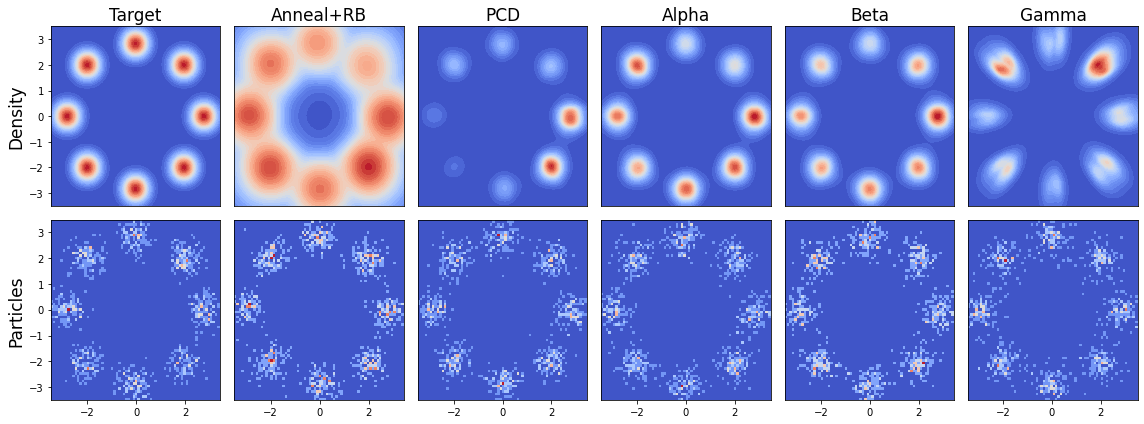

In [47]:
models_names = ['baseline', 'zero', 'alpha', 'beta', 'gamma']
data_name = '8gaussians'
name_map = {'baseline': 'Anneal+RB', 'zero': 'PCD', 
             'alpha': 'Alpha', 'beta': 'Beta', 'gamma': 'Gamma'}
plot_models(models_names, data_name, name_map, 0)
plt.savefig('densities.pdf', bbox_inches='tight')

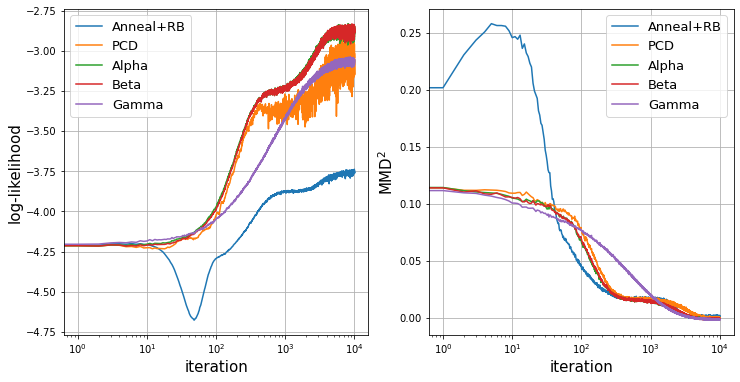

In [58]:
plot_trainings(models_names, data_name, range(9), name_map)
plt.savefig('training_horizontal.pdf', bbox_inches='tight')

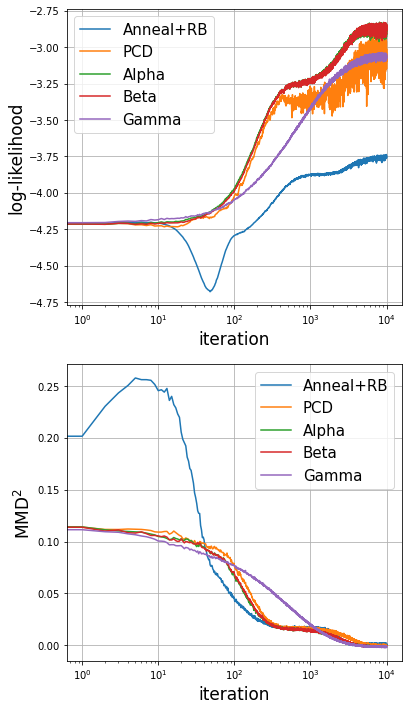

In [48]:
plot_trainings(models_names, data_name, range(9), name_map)
plt.savefig('training.pdf', bbox_inches='tight')

## Baseline + RB

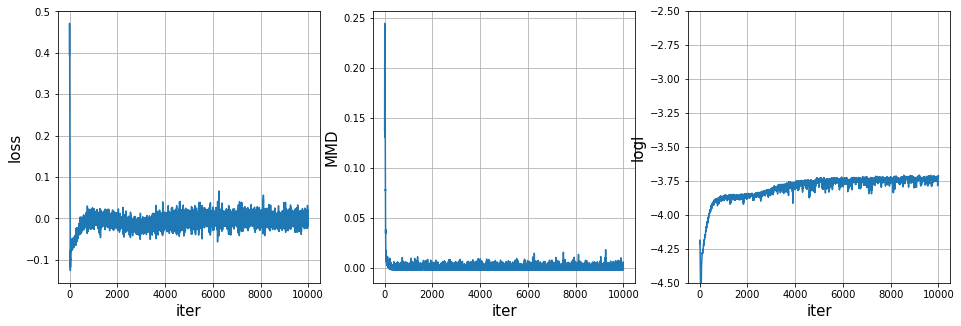

In [41]:
plot_training_process('baseline', '8gaussians')

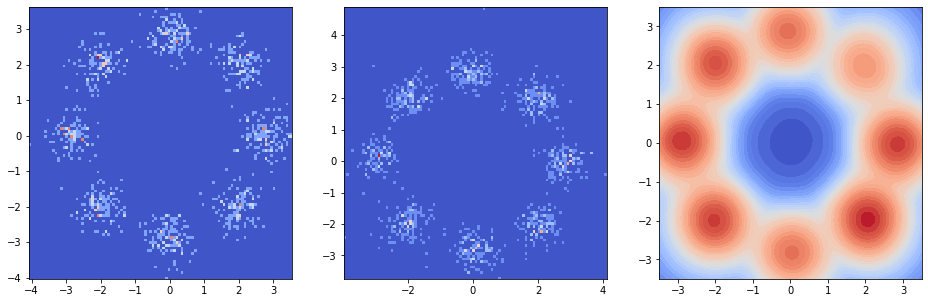

In [37]:
plot_final_model('baseline', '8gaussians')

## Baseline

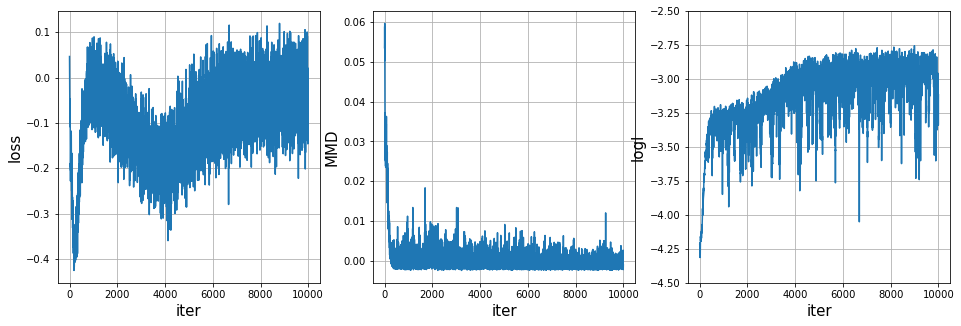

In [10]:
plot_training_process('zero', '8gaussians')

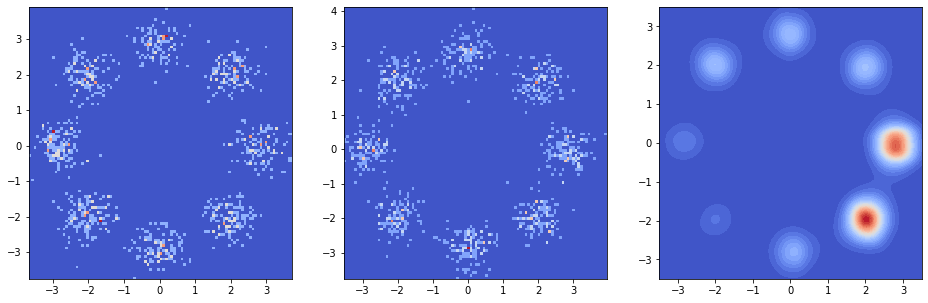

In [39]:
plot_final_model('zero', '8gaussians')

## Alpha

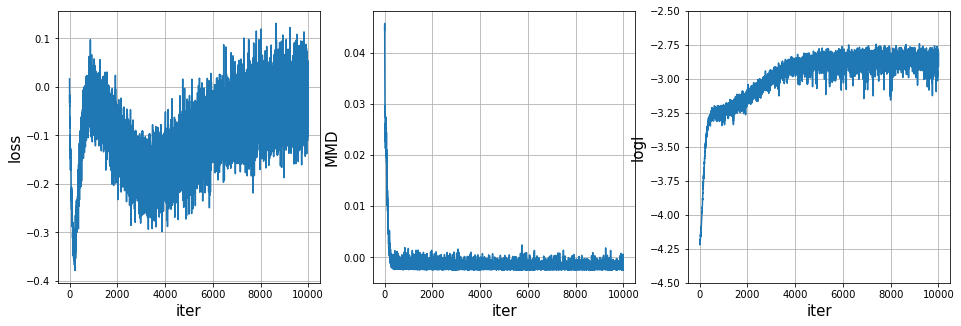

In [12]:
plot_training_process('alpha', '8gaussians')

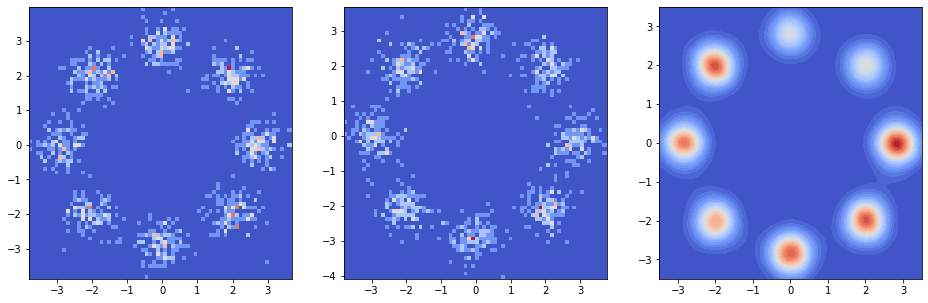

In [13]:
plot_final_model('alpha', '8gaussians')

## Beta

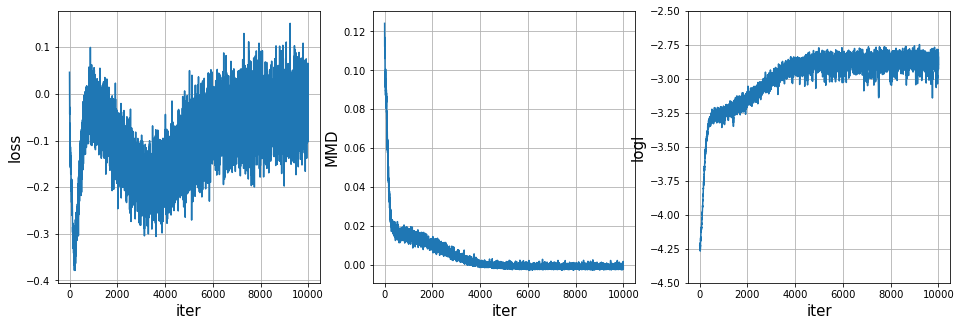

In [149]:
plot_training_process('beta', '8gaussians')

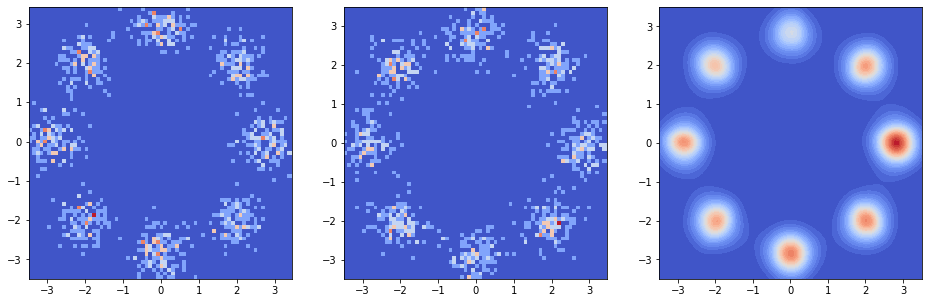

In [150]:
plot_final_model('beta', '8gaussians', False)

## Gamma

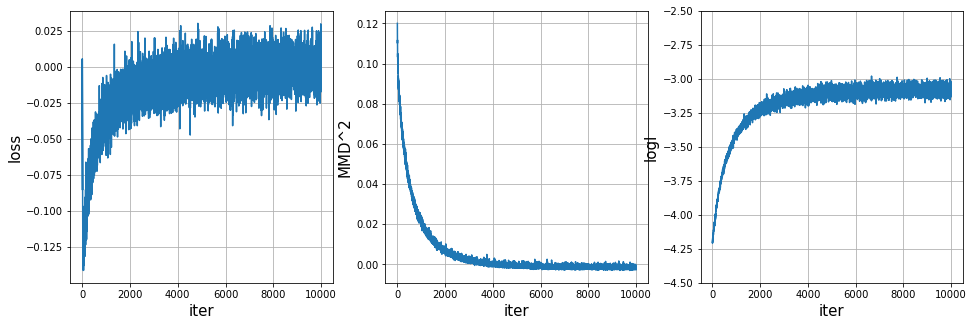

In [106]:
plot_training_process('gamma', '8gaussians')

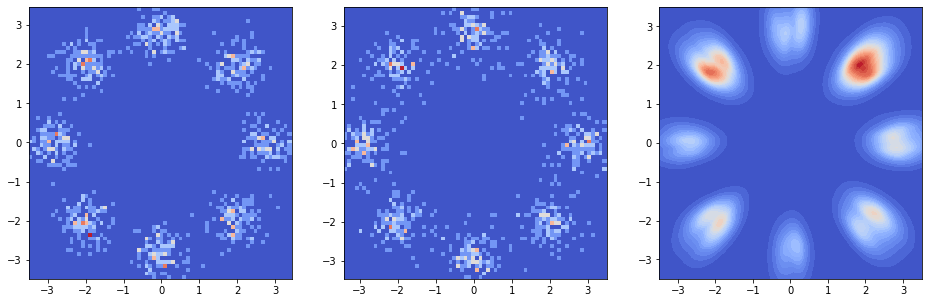

In [107]:
plot_final_model('gamma', '8gaussians', True)

## Beta small batch

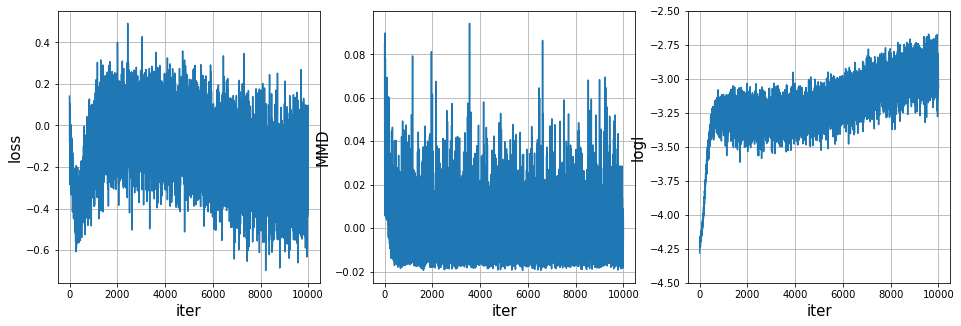

In [468]:
plot_training_process('betaSB_20', '8gaussians')

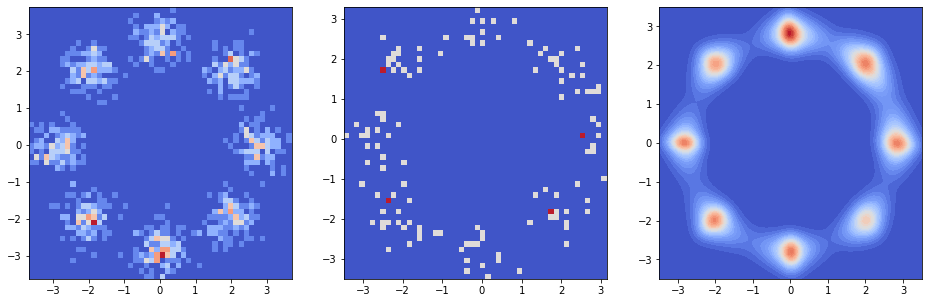

In [469]:
plot_final_model('betaSB_20', '8gaussians')

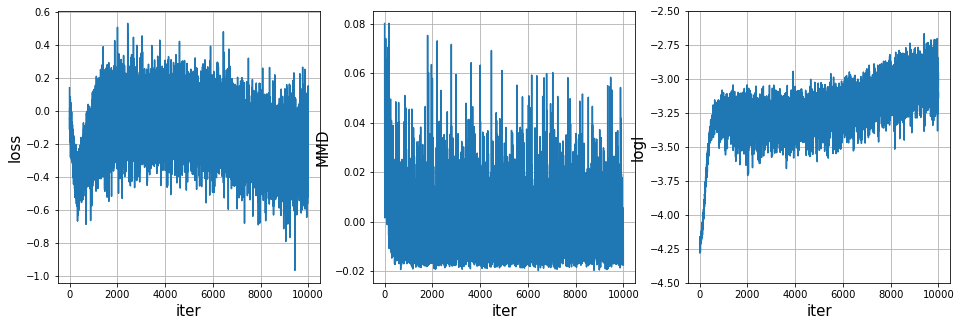

In [521]:
plot_training_process('betaSB', '8gaussians')

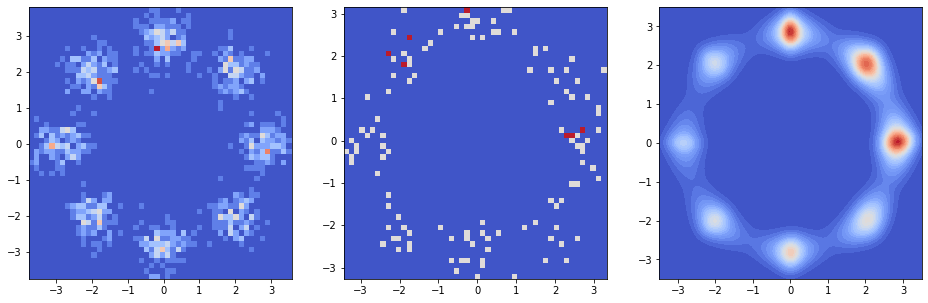

In [522]:
plot_final_model('betaSB', '8gaussians')